# Проект: Временные ряды

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

*Цель проекта:*
Построить модель, которая пожет прогнозировать количество заказов такси на следующий час.

*Задачи:*
- загрузить датафрейм;
- исследовательский анализ данных;
- добавление новых признаков;
- обучение моделей;
- предсказание на тестовых данных;
- итоговые выводы.

**Описание данных:**
- datetime - дата
- num_orders - количество заказов

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data.sort_index(inplace=True)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data = data.resample('1H').sum()

In [7]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Данные были загружены в датафрейм pandas. Выполнено ресемплирование по одному часу. Данные в выборке предоставлены с 01.03.2018 по 31.08.2018 (6 месяцев).

## Анализ

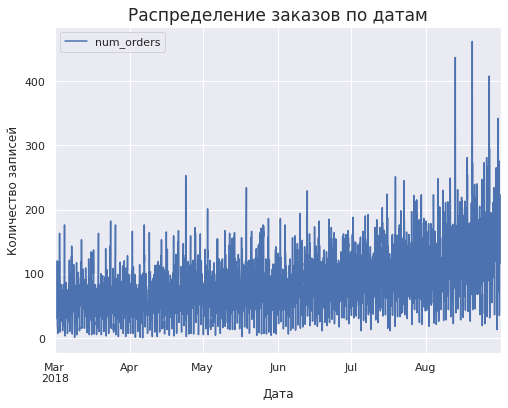

In [8]:
sns.set(rc={'figure.figsize':(8,6)})

data.plot()
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.title('Распределение заказов по датам', size=17)
plt.show()

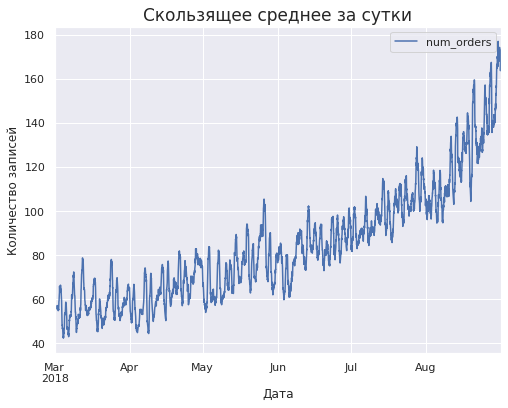

In [9]:
data.rolling(24).mean().plot()
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.title('Скользящее среднее за сутки', size=17)
plt.show()

По графикам видно, что заказы распределены по дням неравномерно.

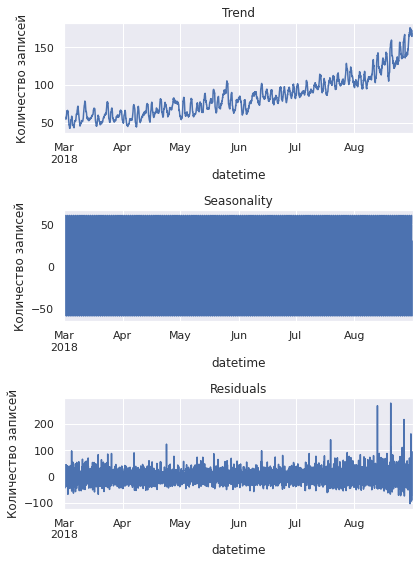

In [10]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
 
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество записей')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Количество записей')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.ylabel('Количество записей')
plt.tight_layout()

На графике тренда видно, что количество заказов растет по месяцам, увеличивая скорость роста в летние месяцы.

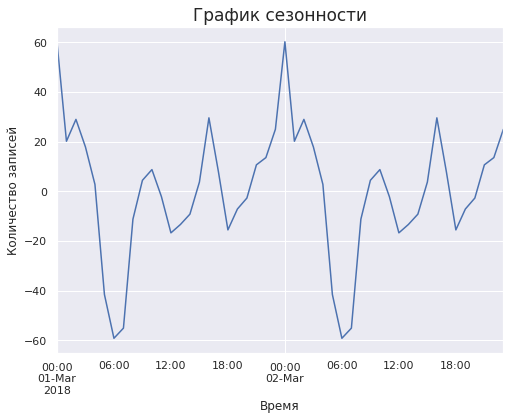

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.xlabel('Время')
plt.ylabel('Количество записей')
plt.title('График сезонности', size=17)
plt.show()

Наблюдается пик заказов в 00:00 и резкий спад в 06:00.

In [12]:
data['dayofweek'] = data.index.dayofweek

In [13]:
data['hour'] = data.index.hour

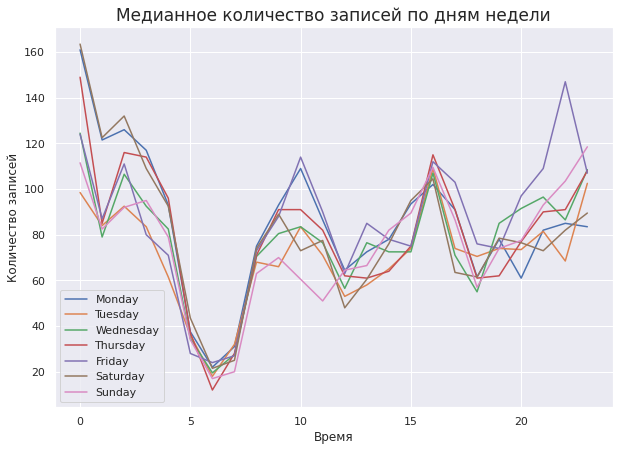

In [14]:
sns.set(rc={'figure.figsize':(10,7)})
for i in range(7):
    data.loc[data['dayofweek'] == i].groupby('hour')['num_orders'].median().plot()
    plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Время')
plt.ylabel('Количество записей')
plt.title('Медианное количество записей по дням недели', size=17)
plt.show()

Заметны небольшие различия в заказах по дням недели. Например, большое количество заказов в 22 часа по пятницам, больше всего заказов с полуночи до 2 часов по понедельникам и субботам, в 10 часов чаще заказывают такси по понедельникам и пятницам.

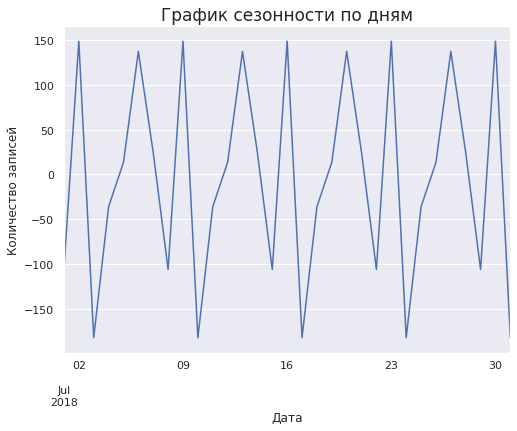

In [15]:
sns.set(rc={'figure.figsize':(8,6)})
seasonal_decompose(data['num_orders'].resample('1D').sum()).seasonal['2018-07-01':'2018-07-31'].plot()
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.title('График сезонности по дням', size=17)
plt.show()

Больше всего заказов в понедельник и пятницу, меньше всего во вторник.

## Обучение

In [16]:
RANDOM_STATE = 1

Добавим новые признаки в датафрейм (день недели и час добавлены ранее): 
- скользящее среднее за последние 2 недели,
- количество заказов в это время за последние 5 дней.

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    
    for lag in range(24, max_lag*24 + 1, 24):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)


    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [18]:
make_features(data, 5, 24 * 14)

Text(0.5, 1.0, 'Автокорреляция')

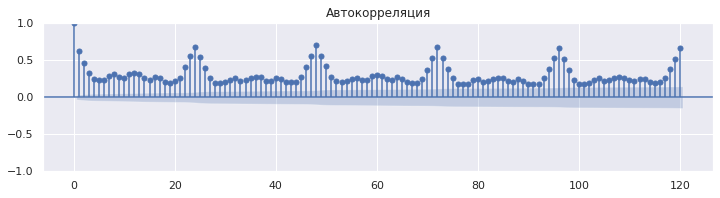

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['num_orders'], lags=120, ax=plt.gca())
plt.title('Автокорреляция')

In [20]:
data = data.dropna()

In [21]:
data.head()

,num_orders,dayofweek,hour,lag_24,lag_48,lag_72,lag_96,lag_120,rolling_mean
datetime,,,,,,,,,
2018-03-15 00:00:00,123,3,0,84.0,91.0,102.0,81.0,117.0,56.491071
2018-03-15 01:00:00,85,3,1,72.0,88.0,153.0,83.0,78.0,56.488095
2018-03-15 02:00:00,55,3,2,39.0,58.0,57.0,36.0,24.0,56.488095
2018-03-15 03:00:00,42,3,3,57.0,63.0,51.0,49.0,44.0,56.440476
2018-03-15 04:00:00,15,3,4,21.0,42.0,49.0,30.0,46.0,56.369048


In [22]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

Для обучение выбраны модели: CatBoostRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(). Предварительная обработка данных не требуется.

In [23]:
pipe = Pipeline([
    ('model', CatBoostRegressor())
])

In [24]:
params = [
   
       {'model':  [CatBoostRegressor(verbose=1000, random_state=RANDOM_STATE)],
        'model__iterations': [700, 1200],
        'model__learning_rate': [0.08, 0.17]},
    
        {'model':  [DecisionTreeRegressor(random_state=RANDOM_STATE)],
         'model__max_depth': range(6, 10)},
    
        {'model': [KNeighborsRegressor()],
         'model__n_neighbors': range(8,12),
         'model__weights': ['uniform', 'distance']}
]



In [25]:
grid_search = GridSearchCV(
    pipe, 
    params, 
    cv=TimeSeriesSplit(3),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(train.drop('num_orders', axis=1), train['num_orders'])

0:	learn: 29.0027451	total: 47.6ms	remaining: 33.3s
699:	learn: 4.1404333	total: 788ms	remaining: 0us
0:	learn: 32.0580924	total: 1.97ms	remaining: 1.38s
699:	learn: 8.1156857	total: 916ms	remaining: 0us
0:	learn: 32.9726826	total: 1.91ms	remaining: 1.33s
699:	learn: 10.5355218	total: 1.03s	remaining: 0us
0:	learn: 27.7799196	total: 1.25ms	remaining: 872ms
699:	learn: 1.2629676	total: 771ms	remaining: 0us
0:	learn: 30.6763979	total: 1.54ms	remaining: 1.08s
699:	learn: 4.1262337	total: 924ms	remaining: 0us
0:	learn: 31.5316960	total: 1.74ms	remaining: 1.22s
699:	learn: 6.3792404	total: 1.02s	remaining: 0us
0:	learn: 29.0027451	total: 1.34ms	remaining: 1.6s
1000:	learn: 2.6469952	total: 1.07s	remaining: 214ms
1199:	learn: 2.0191276	total: 1.29s	remaining: 0us
0:	learn: 32.0580924	total: 1.65ms	remaining: 1.97s
1000:	learn: 6.2116482	total: 1.33s	remaining: 265ms
1199:	learn: 5.2244942	total: 1.59s	remaining: 0us
0:	learn: 32.9726826	total: 1.74ms	remaining: 2.09s
1000:	learn: 8.4372681	t

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostRegressor object at 0x7fcc064be4f0>)]),
             n_jobs=-1,
             param_grid=[{'model': [<catboost.core.CatBoostRegressor object at 0x7fcc064be970>],
                          'model__iterations': [700, 1200],
                          'model__learning_rate': [0.08, 0.17]},
                         {'model': [DecisionTreeRegressor(random_state=1)],
                          'model__max_depth': range(6, 10)},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': range(8, 12),
                          'model__weights': ['uniform', 'distance']}],
             scoring='neg_root_mean_squared_error')

In [26]:
grid_search.best_estimator_

Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x7fcc064cf6a0>)])

In [27]:
grid_search.best_score_

-26.640043216133034

In [28]:
pd.DataFrame(grid_search.cv_results_)[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
0,1.804088,0.002616,{'model': <catboost.core.CatBoostRegressor obj...,-26.640043,1
1,1.800833,0.002435,{'model': <catboost.core.CatBoostRegressor obj...,-27.032029,10
2,2.689180,0.002825,{'model': <catboost.core.CatBoostRegressor obj...,-27.237473,11
3,2.590864,0.002853,{'model': <catboost.core.CatBoostRegressor obj...,-27.311663,12
4,0.006762,0.001587,{'model': DecisionTreeRegressor(random_state=1...,-28.764024,13
5,0.007097,0.001514,{'model': DecisionTreeRegressor(random_state=1...,-29.845361,14
6,0.007599,0.001555,{'model': DecisionTreeRegressor(random_state=1...,-31.488479,15
7,0.008736,0.001650,{'model': DecisionTreeRegressor(random_state=1...,-33.060052,16
8,0.003623,0.013003,"{'model': KNeighborsRegressor(), 'model__n_nei...",-27.031403,9
9,0.003593,0.013003,"{'model': KNeighborsRegressor(), 'model__n_nei...",-27.020910,8


По результатам кросс-валидации лучшей выбрана модель CatBoostRegressor(iterations=700, learning_rate=0.08). Оценка RMSE модели на кросс-валидации 26.6

## Тестирование

Для проверки работы выбранной модели обучим DummyRegressor. 

In [29]:
dr = DummyRegressor(strategy='median')

In [30]:
dr.fit(train.drop('num_orders', axis=1), train['num_orders'])

DummyRegressor(strategy='median')

In [31]:
mean_squared_error(test['num_orders'], dr.predict(test.drop('num_orders', axis=1)), squared=False)

87.38704193436928

In [32]:
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
print("RMSE:", mean_squared_error(test['num_orders'], pred_previous, squared=False))

RMSE: 59.28993648695747


При подстановке предыдущего значения оценка RMSE 59.3. При оценке DummyRegressor(strategy='median) - 87.4

In [33]:
grid_search.best_estimator_.fit(train.drop('num_orders', axis=1), train['num_orders'])

0:	learn: 37.4569041	total: 1.96ms	remaining: 1.37s
699:	learn: 12.6007431	total: 1.17s	remaining: 0us


Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x7fcc064cf6a0>)])

In [34]:
mean_squared_error(test['num_orders'], grid_search.best_estimator_.predict(test.drop('num_orders', axis=1)), squared=False)

38.869068817825664

Оценка модели на тестовых данных 38.8. Данный результат заметно лучше, чем предсказание медианного значения. Однако хуже, чем оценка модели на кросс-валидации. Подобную разницу можно связать с тем, что скорость роста количества заказов в августе больше, чем в остальные месяца. Модель обучена на данных, которые отличаются от тестовых, из-за чего на тестовых данных оценка качества ниже.

## Выводы:

Получена выборка с данными о количестве заказов такси в аэропортах с 01.03.2018 по 31.08.2018 (6 месяцев). Данные были загружены в датафрейм pandas. Выполнено ресемплирование по одному часу. 

Выполнен анализ графиков:
- количество заказов растет по месяцам, увеличивая скорость роста в летние месяцы,
- наблюдается пик заказов в 00:00 и резкий спад в 06:00,
- количество заказов зависит от дня недели. Например, большое количество заказов в 22 часа по пятницам, больше всего заказов с полуночи до 2 часов по понедельникам и субботам, в 10 часов чаще заказывают такси по понедельникам и пятницам.

В датафрейм добавлены признаки: 
- номер месяца, 
- день недели,
- час,
- скользящее среднее за последние 2 недели,
- количество заказов в это время за последние 5 дней.

Обучены модели: CatBoostRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(), выполнен подбор параметров. По результатам кросс-валидации лучшей выбрана модель CatBoostRegressor(iterations=700, learning_rate=0.08). Оценка RMSE модели на кросс-валидации 24.8.

Оценка модели на тестовых данных 38.8. Данный результат заметно лучше, чем предсказание медианного значения. Однако хуже, чем оценка модели на кросс-валидации. Подобную разницу можно связать с тем, что скорость роста количества заказов в августе больше, чем в остальные месяца. Модель обучена на данных, которые отличаются от тестовых, из-за чего на тестовых данных оценка качества ниже.